In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
import cv2


In [2]:
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy

## 获取数据

In [3]:
train_irimgs_path = glob.glob('data/MSRS-main/train/ir/*.png')
train_viimgs_path = glob.glob('data/MSRS-main/train/vi/*.png')

# train_irimgs_path = glob.glob('data/TNO/ir/*.png')
# train_viimgs_path = glob.glob('data/TNO/vi/*.png')

test_irimgs_path = glob.glob('data/TNO/ir/*.png')
test_viimgs_path = glob.glob('data/TNO/vi/*.png')

In [4]:
transform = transforms.Compose([
     transforms.Resize(256),
     transforms.CenterCrop(256),
     transforms.ToTensor(),
     transforms.Normalize(mean=0.5,std=0.5)
])

In [5]:
class FusionDataset(data.Dataset):
    def __init__(self,ir_path,vi_path):
        self.ir_path = train_irimgs_path
        self.vi_path = train_viimgs_path
    def __getitem__(self,idx):
        # 得到路径
        vi_path = self.vi_path[idx]
        ir_path = self.ir_path[idx]
        # 根据路径得到图片
        vi_img = Image.open(vi_path)
        ir_img = Image.open(ir_path) #ir红外读取为灰度图了
        
        vi_img = vi_img.convert('L') # 可见光转灰度图
        
        # vi_img = vi_img.convert('RGB')# 将灰度图转换为三通道再变化
        # ir_img = ir_img.convert('RGB')# 将灰度图转换为三通道再变化
        vi_img = transform(vi_img)
        ir_img = transform(ir_img)
        return vi_img,ir_img
    def __len__(self):
        return len(self.ir_path)

In [6]:
train_ds = FusionDataset(train_irimgs_path,train_viimgs_path)
test_ds = FusionDataset(test_irimgs_path,test_viimgs_path)

In [7]:
BATCHSIZE = 64
#训练集随机打乱
train_dl = data.DataLoader(dataset=train_ds,
                          batch_size=BATCHSIZE,
                          shuffle=True)

test_dl = data.DataLoader(dataset=test_ds,
                          batch_size=BATCHSIZE,
                          shuffle=False)

In [8]:
vi_batch,ir_batch = next(iter(train_dl))

In [9]:
ir_batch.shape,vi_batch.shape

(torch.Size([64, 1, 256, 256]), torch.Size([64, 1, 256, 256]))

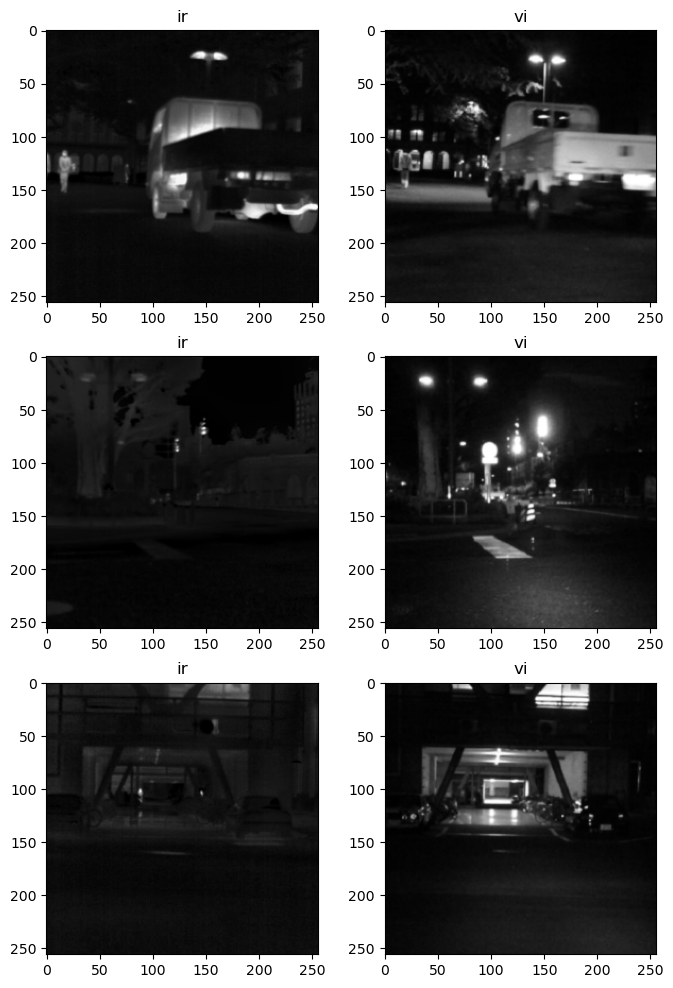

In [10]:
plt.figure(figsize = (8,12))
for i,(vi,ir) in enumerate(zip(vi_batch[:3],ir_batch[:3])):
    ir = (ir.permute(1,2,0).numpy()+1)/2
    vi = (vi.permute(1,2,0).numpy()+1)/2
    # ir = (ir.permute(1,2,0).numpy())
    # vi = (vi.permute(1,2,0).numpy())
    plt.subplot(3,2,2*i+1)
    plt.title('ir')
    plt.imshow(ir,cmap='gray')
    plt.subplot(3,2,2*i+2)
    plt.title('vi')
    plt.imshow(vi,cmap='gray')

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Define the encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        # Define the decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )
    def forward(self,vi,ir):
        
        x = torch.cat([vi,ir],dim=1)
        # print(f'初始图像：{x.shape}')
        x = self.encoder(x)
        # print(f'编码器图像：{x.shape}')
        x = self.decoder(x)
        # print(f'解码器图像：{x.shape}')
        return x

In [12]:
#定义下采样模块
class Downsample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Downsample,self).__init__()
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,
                     kernel_size=3,
                     stride = 2,
                     padding=1),
            nn.LeakyReLU(inplace=True)
        )
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self,x,is_bn=True):
    # 生成器的输出层和判别器的输入层不使用BN
        x = self.conv_relu(x)
        if is_bn:
            x = self.bn(x)
        return x

In [13]:
#定义上采样模块
class Upsample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Upsample,self).__init__()
        self.upconv_relu = nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,
                     kernel_size=3,
                     stride = 2,
                     padding=1,
                     output_padding=1),
            nn.LeakyReLU(inplace=True)
        )
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self,x,is_drop=False):
    # 生成器的输出层和判别器的输入层不使用BN
        x = self.upconv_relu(x)
        x = self.bn(x)
        if is_drop:
            x = F.dropout2d(x)
        return x

In [14]:
#下采样六次上采样5次
class Unet(nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.down1 = Downsample(6,64)
        self.down2 = Downsample(64,128)
        self.down3 = Downsample(128,256)
        self.down4 = Downsample(256,512)
        self.down5 = Downsample(512,512)
        self.down6 = Downsample(512,512)

        self.up1 = Upsample(512,512)
        self.up2 = Upsample(1024,512)
        self.up3 = Upsample(1024,256)
        self.up4 = Upsample(512,128)
        self.up5 = Upsample(256,64)
        
        self.last = nn.ConvTranspose2d(128,3,
                                      kernel_size=3,
                                      stride=2,
                                      padding=1,
                                      output_padding=1)
    def forward(self,vi,ir):
        x = torch.cat([vi,ir],dim=1)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x6 = self.down6(x5)

        x6 = self.up1(x6,is_drop = True)
        x6 = torch.cat([x6,x5],dim = 1)

        x6 = self.up2(x6,is_drop = True)
        x6 = torch.cat([x6,x4],dim = 1)

        x6 = self.up3(x6,is_drop = True)
        x6 = torch.cat([x6,x3],dim = 1)

        x6 = self.up4(x6)
        x6 = torch.cat([x6,x2],dim = 1)

        x6 = self.up5(x6)
        x6 = torch.cat([x6,x1],dim = 1)

        x6 = torch.tanh(self.last(x6))

        return x6

In [15]:
# 自定义神经网络层来提取图像的边缘细节并保持形状相同
class EdgeDetectionLayer(nn.Module):
    def __init__(self):
        super(EdgeDetectionLayer, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
    def forward(self, x):
        edge_map = F.conv2d(x, weight=torch.Tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]*3]).to(x.device), padding=1)
        return x + edge_map

In [16]:
# 自定义神经网络层来提取图像的频谱信息
class FourierTransformLayer(nn.Module):
    def __init__(self):
        super(FourierTransformLayer, self).__init__()
    def forward(self, x):
        # 进行傅里叶变换
        x_fft = torch.fft.fftn(x, dim=(-2, -1))
        return x_fft.real

In [17]:
net = FourierTransformLayer()
output = net(ir_batch)

In [18]:
output.shape

torch.Size([64, 1, 256, 256])

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.ae = Autoencoder()
        self.unet = Unet()
        self.fft = FourierTransformLayer()
        self.edge = EdgeDetectionLayer()
    def forward(self,vi,ir):
        # feature_fft = self.fft(vi) #[b,3,256,256]可见光的频谱信息
        # feature_edge = self.edge(ir) #[b,3,256,256]红外光的边缘信息
        # feature_unet = self.unet(feature_edge,feature_fft) #[b,3,256,256]利用Unet进行融合
        x = self.ae(vi,ir)
        # x = feature_edge + feature_fft
        # x = self.ae(x)
        return x

In [20]:
class Discriminator(nn.Module):
    # ir + vi concat
    def __init__(self):
        super(Discriminator,self).__init__()
        self.down1 = Downsample(1,64)
        self.down2 = Downsample(64,128)
        self.conv1 = nn.Conv2d(128,256,3)
        self.bn = nn.BatchNorm2d(256)
        self.last = nn.Conv2d(256,1,3)
    def forward(self,vi):
        # x = torch.cat([ir,vi],axis = 1)
        # x = ir*0.5 + vi*0.5
        x = vi
        x = self.down1(x,is_bn=False)
        x = self.down2(x,is_bn=False)
        x = F.dropout2d(self.bn(F.leaky_relu(self.conv1(x))))
        x = torch .sigmoid(self.last(x))
        return x

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
gen = Generator().to(device)
# dis =torchvision.models.resnet18()
dis = Discriminator().to(device)

In [23]:
# fc = nn.Sequential(
#     nn.Linear(in_features=512, out_features=10, bias=True),
#     # nn.Sigmoid()
#     # nn.Softmax()
# )
# dis.fc = fc
# dis.fc = fc
# dis = dis.to(device)
if torch.cuda.device_count() > 1: #多卡训练
    gen = nn.DataParallel(gen)  # 就在这里wrap一下，模型就会使用所有的GPU
    dis = nn.DataParallel(dis)  # 就在这里wrap一下，模型就会使用所有的GPU

In [24]:
o = dis(ir_batch.to(device))

In [25]:
o[0].shape

torch.Size([1, 60, 60])

In [26]:
d_optimizer = torch.optim.Adam(dis.parameters(),lr = 1e-4,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(gen.parameters(),lr = 1e-4,betas=(0.5,0.999))

In [27]:
# 定义损失函数
# loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.MSELoss()


In [28]:
LAMDA = 7

In [29]:
def calculate_metrics(vi, ir,fusion):
    # Information Entropy (EN)
    def calculate_entropy(fusion):
        img_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        entropy_value = shannon_entropy(img_gray)
        return entropy_value

    # Standard Deviation (SD)
    def calculate_sd(fusion):
        img_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        sd_value = np.std(img_gray)
        return sd_value

    # Structural Similarity Index (SSIM)
    def calculate_ssim(vi, ir ,fusion):
        img1_gray = cv2.cvtColor(vi, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(ir, cv2.COLOR_BGR2GRAY)
        fusion_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        ssim_index_A, _ = ssim(img1_gray, fusion_gray, full=True)
        ssim_index_B, _ = ssim(img2_gray, fusion_gray, full=True)
        return (ssim_index_A + ssim_index_B)/2 

    # Correlation Coefficient (CC)
    def calculate_cc(vi, ir ,fusion):
        img1_flat = vi.flatten()
        img2_flat = ir.flatten()
        fusion_flat = fusion.flatten()
        correlation_coefficient_A = np.corrcoef(img1_flat, fusion_flat)[0, 1]
        correlation_coefficient_B = np.corrcoef(img2_flat, fusion_flat)[0, 1]
        return (correlation_coefficient_A + correlation_coefficient_B)/2

    # Spatial Frequency (SF)
    def calculate_sf(fusion):
        img_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        f = np.fft.fft2(img_gray)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        spatial_frequency = np.sum(magnitude_spectrum) / img_gray.size
        return spatial_frequency

    # Variable Luminance Fusion Index (VLF)
    def calculate_vlf(vi, ir ,fusion):
        img1_gray = cv2.cvtColor(vi, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(ir, cv2.COLOR_BGR2GRAY)
        fusion_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        
        vlf_value_A = np.sum(np.abs(img1_gray - fusion_gray)) / img1_gray.size
        vlf_value_B = np.sum(np.abs(img2_gray - fusion_gray)) / img2_gray.size
        return (vlf_value_A + vlf_value_B)/2

    # Calculate metrics
    entropy_value = calculate_entropy(fusion)
    sd_value = calculate_sd(fusion)
    ssim_value = calculate_ssim(vi, ir,fusion)
    cc_value = calculate_cc(vi, ir,fusion)
    sf_value = calculate_sf(fusion)
    vlf_value = calculate_vlf(vi, ir,fusion)
    return {
        'Entropy': entropy_value,
        'Standard Deviation': sd_value,
        'SSIM': ssim_value,
        'Correlation Coefficient': cc_value,
        'Spatial Frequency': sf_value,
        'Variable Luminance Fusion Index': vlf_value
    }

In [30]:
def genarate_images(model,ir,vi):
    prediction = model(vi,ir)
    prediction = prediction.permute(0,2,3,1).detach().cpu().numpy()
    ir = ir.permute(0,2,3,1).cpu().numpy()
    vi = vi.permute(0,2,3,1).cpu().numpy()
    plt.figure(figsize=(10,10))
    display_list = [ir[0],vi[0],prediction[0]]
    fusion_result = None
    # fusion_result = calculate_metrics(vi[0], ir[0],prediction[0])
    # print(fusion_result)
    title = ['ir','vi','fusion']
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5,cmap='gray')
        plt.axis('off')
    plt.show()
    return fusion_result

In [31]:
def gradient(x):
    # 定义一个函数来计算图像的梯度（或拉普拉斯算子的卷积结果）。
    with torch.no_grad():
        # 使用不追踪梯度的上下文，因为此操作是在推理过程中使用，不需要进行反向传播。
        laplace = [[0.0, -1.0, 0.0], [-1.0, 4.0, -1.0], [0.0, -1.0, 0.0]]
        # 定义拉普拉斯核，这是一个用于图像二阶导数近似的卷积核。
        kernel = torch.FloatTensor(laplace).unsqueeze(0).unsqueeze(0).to(device)
        # 将拉普拉斯核转换为浮点张量，并添加两个维度以匹配卷积操作的要求，
        # 然后将其移动到指定的设备（如GPU或CPU）。
        return F.conv2d(x, kernel, stride=1, padding=1)
        # 对输入的x（图像或特征图）应用2D卷积，使用定义的拉普拉斯核，
        # 步长设为1，填充设为1（以保持图像尺寸不变）并返回结果。

In [32]:
vi_input = vi_batch[1].unsqueeze(0)
ir_input = ir_batch[1].unsqueeze(0)



In [33]:
vii = gradient(vi_input.cuda())
irr = gradient(ir_input.cuda())
vii = vii.squeeze().unsqueeze(0)
irr = irr.squeeze().unsqueeze(0)

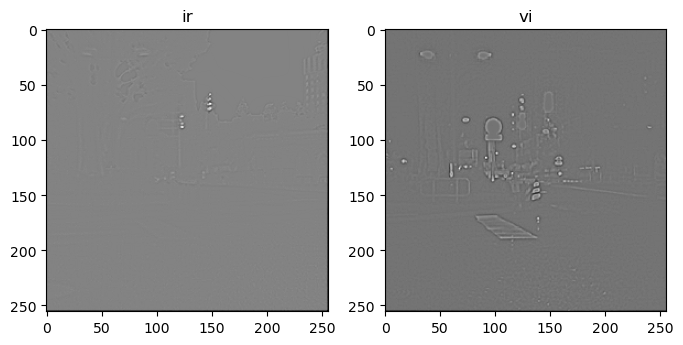

In [34]:
plt.figure(figsize = (8,12))
vii = (vii.cpu().permute(1,2,0).numpy()+1)/2
irr = (irr.cpu().permute(1,2,0).numpy()+1)/2
plt.subplot(1,2,1)
plt.title('ir')
plt.imshow(irr,cmap='gray')
plt.subplot(1,2,2)
plt.title('vi')
plt.imshow(vii,cmap='gray')

In [35]:
def sobel_edge_detection(x):
    # 定义 Sobel 算子核，用于计算水平和垂直方向上的梯度
    sobel_x = [[-1, 0, 1], 
               [-2, 0, 2], 
               [-1, 0, 1]]
    sobel_y = [[-1, -2, -1], 
               [0, 0, 0], 
               [1, 2, 1]]

    sobel_kernel_x = torch.FloatTensor(sobel_x).unsqueeze(0).unsqueeze(0).to(device)
    sobel_kernel_y = torch.FloatTensor(sobel_y).unsqueeze(0).unsqueeze(0).to(device)

    # 分别计算水平和垂直方向上的梯度
    grad_x = F.conv2d(x, sobel_kernel_x, stride=1, padding=1)
    grad_y = F.conv2d(x, sobel_kernel_y, stride=1, padding=1)

    # 综合水平和垂直梯度，通常可以通过欧氏距离或梯度幅值得到边缘强度
    edges = torch.sqrt(grad_x.pow(2) + grad_y.pow(2))

    return edges

In [36]:
vii = sobel_edge_detection(vi_input.cuda())
irr = sobel_edge_detection(ir_input.cuda())
vii = vii.squeeze().unsqueeze(0)
irr = irr.squeeze().unsqueeze(0)

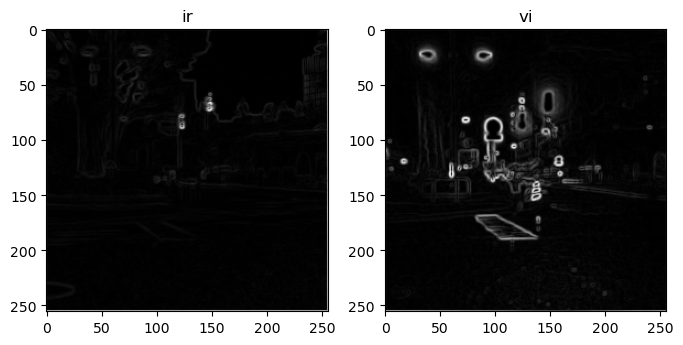

In [37]:
plt.figure(figsize = (8,12))
vii = (vii.cpu().permute(1,2,0).numpy()+1)/2
irr = (irr.cpu().permute(1,2,0).numpy()+1)/2
plt.subplot(1,2,1)
plt.title('ir')
plt.imshow(irr,cmap='gray')
plt.subplot(1,2,2)
plt.title('vi')
plt.imshow(vii,cmap='gray')

In [38]:
def gen_loss_func(self, fusion_output, fusion_img, vis_img, inf_img):
    epsilon=5.0  # 设置epsilon值为5.0
    lda = 100
    # 定义生成器损失函数，判别器输出、融合图像、可见光图像和红外图像作为输入。
    gan_loss = torch.mean(
        torch.square(fusion_output - torch.Tensor(fusion_output.shape).uniform_(0.7, 1.2).to(device)))
    # 计算GAN损失，它是融合输出与一个随机数（介于0.7和1.2之间）的平方差的均值。
    # 这里使用了平方差而非传统的对数差以提供平滑的梯度。
    content_loss = torch.mean(torch.square(fusion_img - inf_img)) + \
                   self.epsilon * torch.mean(torch.square(gradient(fusion_img) -gradient(vis_img)))
    # 计算内容损失，该损失由两部分组成：
    # 第一部分是融合图像与红外图像的平方差的均值；
    # 第二部分是融合图像与可见光图像的梯度平方差的均值，乘以一个小的正数epsilon，以平衡两部分损失的权重。
    return gan_loss + lda * content_loss, gan_loss, self.lda * content_loss
    # 返回总损失，它是GAN损失与内容损失的加权和，以及分别返回GAN损失和内容损失。
    # lda是一个超参数，用于平衡GAN损失和内容损失的重要性。

Epoch: 0 

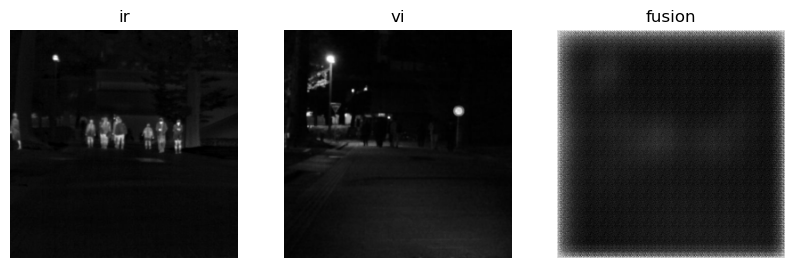

D_epoch_loss:0.4214770320583792,G_epoch_loss4.582662119584925
Epoch: 1 D_epoch_loss:0.31951938657199636,G_epoch_loss2.108854714561911
Epoch: 2 D_epoch_loss:0.26047780320924874,G_epoch_loss1.8498338531045353
Epoch: 3 D_epoch_loss:0.23066962992443757,G_epoch_loss1.6610462385065414
Epoch: 4 D_epoch_loss:0.18883545170812047,G_epoch_loss1.591292893185335
Epoch: 5 D_epoch_loss:0.16401459189022288,G_epoch_loss1.5706210206536686
Epoch: 6 D_epoch_loss:0.13870402907623963,G_epoch_loss1.5939117740182316
Epoch: 7 D_epoch_loss:0.12413192847195793,G_epoch_loss1.605430659125833
Epoch: 8 D_epoch_loss:0.11092197763569214,G_epoch_loss1.620467228047988
Epoch: 9 D_epoch_loss:0.09957581320229698,G_epoch_loss1.6520026010625504
Epoch: 10 D_epoch_loss:0.09156487268560073,G_epoch_loss1.6659969091415405
Epoch: 11 D_epoch_loss:0.08388056343092638,G_epoch_loss1.6766846039715935
Epoch: 12 D_epoch_loss:0.07961157665533178,G_epoch_loss1.6915596022325403
Epoch: 13 D_epoch_loss:0.07751041256329592,G_epoch_loss1.695137

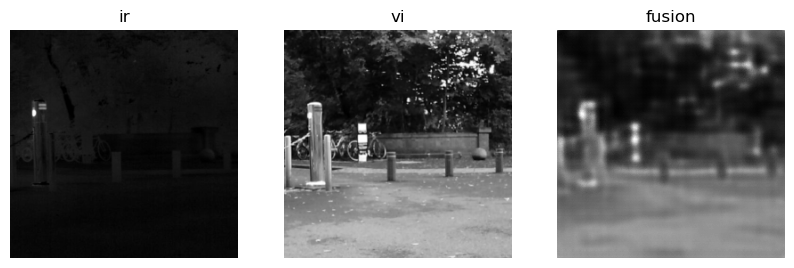

D_epoch_loss:0.030435706981841254,G_epoch_loss1.7829463832518633
Epoch: 50 D_epoch_loss:0.02870511548484073,G_epoch_loss1.783166899400599
Epoch: 51 D_epoch_loss:0.03682689171503572,G_epoch_loss1.7701947057948393
Epoch: 52 D_epoch_loss:0.02769762628218707,G_epoch_loss1.7839078622705795
Epoch: 53 D_epoch_loss:0.03366437466705546,G_epoch_loss1.7746283727533676
Epoch: 54 D_epoch_loss:0.029342928901314735,G_epoch_loss1.7814098035587984
Epoch: 55 D_epoch_loss:0.026778062695966047,G_epoch_loss1.7834191532695995
Epoch: 56 D_epoch_loss:0.02747136474970509,G_epoch_loss1.7793326447991764
Epoch: 57 D_epoch_loss:0.029593911569784668,G_epoch_loss1.7779895768446081
Epoch: 58 D_epoch_loss:0.03129418522996061,G_epoch_loss1.7758849158006556
Epoch: 59 D_epoch_loss:0.02547249263700317,G_epoch_loss1.7843620075899012
Epoch: 60 D_epoch_loss:0.024864622117841944,G_epoch_loss1.7807487670113058
Epoch: 61 D_epoch_loss:0.024980415097054315,G_epoch_loss1.7843215746038101
Epoch: 62 D_epoch_loss:0.027531550320632318

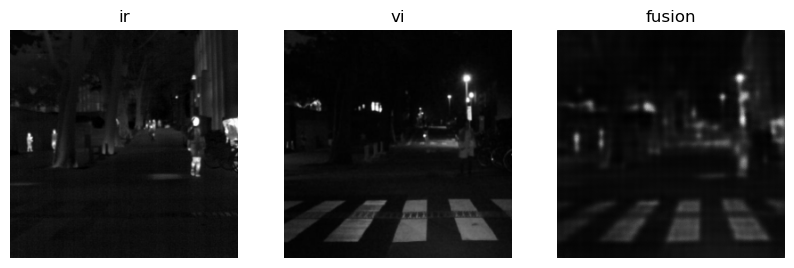

D_epoch_loss:0.01938240054775687,G_epoch_loss1.7748148932176477
Epoch: 99 D_epoch_loss:0.01876328923903844,G_epoch_loss1.7716930543675142
Epoch: 100 D_epoch_loss:0.019152640967684632,G_epoch_loss1.774855003637426
Epoch: 101 D_epoch_loss:0.021193087539252115,G_epoch_loss1.7726828000124764
Epoch: 102 D_epoch_loss:0.02026242740890559,G_epoch_loss1.7666598979164572
Epoch: 103 D_epoch_loss:0.023136200602440274,G_epoch_loss1.7630405215656055
Epoch: 104 D_epoch_loss:0.020176793558194357,G_epoch_loss1.7685255513471716
Epoch: 105 D_epoch_loss:0.0188348906881669,G_epoch_loss1.7766636049046236
Epoch: 106 D_epoch_loss:0.017692624153021502,G_epoch_loss1.7685628358055563
Epoch: 107 D_epoch_loss:0.01871273688533727,G_epoch_loss1.7694299711900598
Epoch: 108 D_epoch_loss:0.019801440155681443,G_epoch_loss1.7627594190485336
Epoch: 109 D_epoch_loss:0.01719866649192922,G_epoch_loss1.7677651012645048
Epoch: 110 D_epoch_loss:0.01707651520914891,G_epoch_loss1.7731190709506763
Epoch: 111 D_epoch_loss:0.0221994

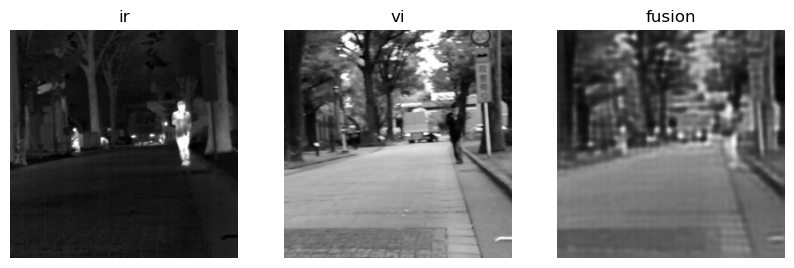

D_epoch_loss:0.015363071826012695,G_epoch_loss1.7590933196684893
Epoch: 148 D_epoch_loss:0.015122995492728317,G_epoch_loss1.7531889396555282
Epoch: 149 D_epoch_loss:0.015222488464239766,G_epoch_loss1.7564381080515243
Epoch: 150 D_epoch_loss:0.014737431562560447,G_epoch_loss1.7554223817937515
Epoch: 151 D_epoch_loss:0.014403026441440862,G_epoch_loss1.756459215108086
Epoch: 152 D_epoch_loss:0.014032069100614856,G_epoch_loss1.7558456519070793
Epoch: 153 D_epoch_loss:0.014205085935399812,G_epoch_loss1.7554899033378153
Epoch: 154 D_epoch_loss:0.02023179944166366,G_epoch_loss1.7454353851430557
Epoch: 155 D_epoch_loss:0.018972315770738265,G_epoch_loss1.7440554043825935
Epoch: 156 D_epoch_loss:0.014661709065822995,G_epoch_loss1.7540736408794628
Epoch: 157 D_epoch_loss:0.014377244200338335,G_epoch_loss1.7560749825309305
Epoch: 158 D_epoch_loss:0.018712446093559265,G_epoch_loss1.7501853564206291
Epoch: 159 D_epoch_loss:0.015814004137235528,G_epoch_loss1.7488991512971765
Epoch: 160 D_epoch_loss:0

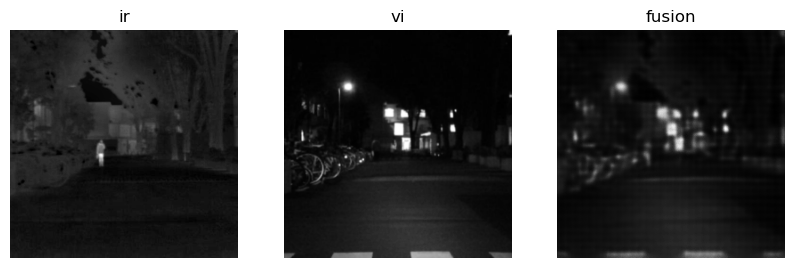

D_epoch_loss:0.01306042228551472,G_epoch_loss1.7428502756006576
Epoch: 197 D_epoch_loss:0.012086481239427538,G_epoch_loss1.74185549511629
Epoch: 198 D_epoch_loss:0.012758512488182853,G_epoch_loss1.7424088926876293
Epoch: 199 D_epoch_loss:0.014646995867438176,G_epoch_loss1.7386608334148632
Epoch: 200 D_epoch_loss:0.07595403492450714,G_epoch_loss1.645758453537436
Epoch: 201 D_epoch_loss:0.019118941115105852,G_epoch_loss1.7600457878673779
Epoch: 202 D_epoch_loss:0.016064460444099763,G_epoch_loss1.7619734792148365
Epoch: 203 D_epoch_loss:0.015360017471453723,G_epoch_loss1.7596669547698076
Epoch: 204 D_epoch_loss:0.014241400777417071,G_epoch_loss1.7553150723962223
Epoch: 205 D_epoch_loss:0.013861281961640892,G_epoch_loss1.7520621594260721
Epoch: 206 D_epoch_loss:0.01339536954594009,G_epoch_loss1.750635729116552
Epoch: 207 D_epoch_loss:0.014072191244100822,G_epoch_loss1.7467219408820658
Epoch: 208 D_epoch_loss:0.012555297683267033,G_epoch_loss1.7475073968662935
Epoch: 209 D_epoch_loss:0.0118

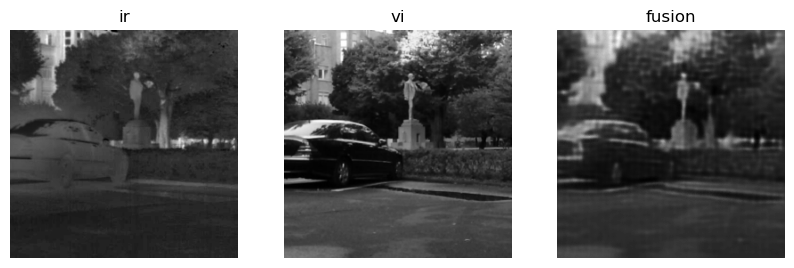

D_epoch_loss:0.011659549220519908,G_epoch_loss1.7258636390461641
Epoch: 246 D_epoch_loss:0.01046218684710124,G_epoch_loss1.7271439959021175
Epoch: 247 D_epoch_loss:0.012630490750512657,G_epoch_loss1.7233368158340454
Epoch: 248 D_epoch_loss:0.014856447191799389,G_epoch_loss1.7123725484399235
Epoch: 249 D_epoch_loss:0.012421517495942466,G_epoch_loss1.7246002800324385
Epoch: 250 D_epoch_loss:0.011540166321484482,G_epoch_loss1.7234654286328484
Epoch: 251 D_epoch_loss:0.0098419940811308,G_epoch_loss1.724387442364412
Epoch: 252 D_epoch_loss:0.010275221429765224,G_epoch_loss1.7226521758472217
Epoch: 253 D_epoch_loss:0.010667062035816558,G_epoch_loss1.723977236186757
Epoch: 254 D_epoch_loss:0.01126262342886013,G_epoch_loss1.7211812874850105
Epoch: 255 D_epoch_loss:0.011404846110107267,G_epoch_loss1.7215215809205
Epoch: 256 D_epoch_loss:0.011250628514544052,G_epoch_loss1.72066769880407
Epoch: 257 D_epoch_loss:0.010078238104196155,G_epoch_loss1.7227420175776762
Epoch: 258 D_epoch_loss:0.01115203

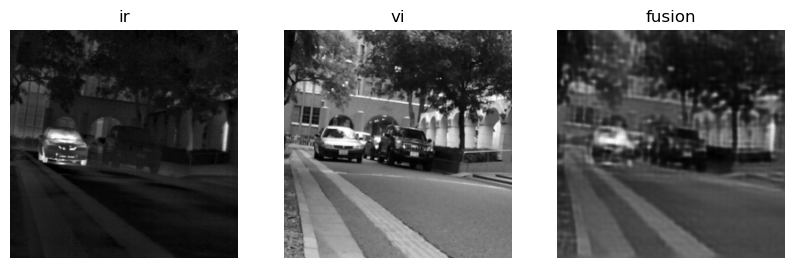

D_epoch_loss:0.01422772282624946,G_epoch_loss1.7298742532730103
Epoch: 295 D_epoch_loss:0.012107227435883354,G_epoch_loss1.731344089788549
Epoch: 296 D_epoch_loss:0.01692690420895815,G_epoch_loss1.7213041642132927
Epoch: 297 D_epoch_loss:0.01535016659866361,G_epoch_loss1.7144400863086475
Epoch: 298 D_epoch_loss:0.013025338980643189,G_epoch_loss1.7199651002883911
Epoch: 299 D_epoch_loss:0.012210316599949318,G_epoch_loss1.7197417301290177
Epoch: 300 D_epoch_loss:0.010879035655628233,G_epoch_loss1.7207940045525045
Epoch: 301 D_epoch_loss:0.010312888004324016,G_epoch_loss1.7181568285998177
Epoch: 302 D_epoch_loss:0.009696703924633124,G_epoch_loss1.7155870269326603
Epoch: 303 D_epoch_loss:0.009532633566242807,G_epoch_loss1.7182257946799784
Epoch: 304 D_epoch_loss:0.011654209674281232,G_epoch_loss1.713366052683662
Epoch: 305 D_epoch_loss:0.01061838777626262,G_epoch_loss1.7101593157824349
Epoch: 306 D_epoch_loss:0.009307516683988711,G_epoch_loss1.7123989638160257
Epoch: 307 D_epoch_loss:0.009

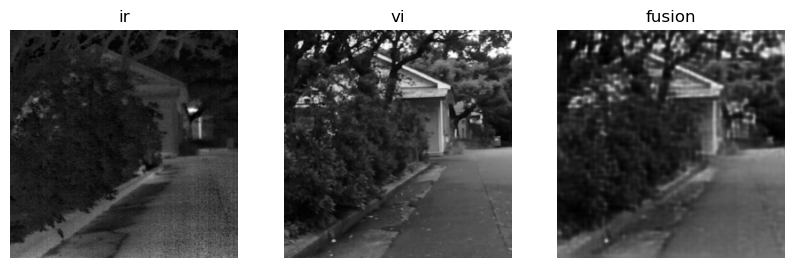

D_epoch_loss:0.008612388909301338,G_epoch_loss1.6952429308610804
Epoch: 344 D_epoch_loss:0.008051218108876664,G_epoch_loss1.695508781601401
Epoch: 345 D_epoch_loss:0.007655125138733317,G_epoch_loss1.6953559062060188
Epoch: 346 D_epoch_loss:0.007976018221062772,G_epoch_loss1.6961598817039938
Epoch: 347 D_epoch_loss:0.007577084497932126,G_epoch_loss1.6935580968856812
Epoch: 348 D_epoch_loss:0.008009364828467369,G_epoch_loss1.6952988470301908
Epoch: 349 D_epoch_loss:0.04637392670573557,G_epoch_loss1.6413445542840397
Epoch: 350 D_epoch_loss:0.012653208830777337,G_epoch_loss1.7101269960403442
Epoch: 351 D_epoch_loss:0.011224693344796406,G_epoch_loss1.7094974237329819
Epoch: 352 D_epoch_loss:0.009884384625098285,G_epoch_loss1.7092085866367115
Epoch: 353 D_epoch_loss:0.009383430622298928,G_epoch_loss1.708508428405313
Epoch: 354 D_epoch_loss:0.009696802370907628,G_epoch_loss1.7079819721334122
Epoch: 355 D_epoch_loss:0.00800297677736072,G_epoch_loss1.70722478277543
Epoch: 356 D_epoch_loss:0.008

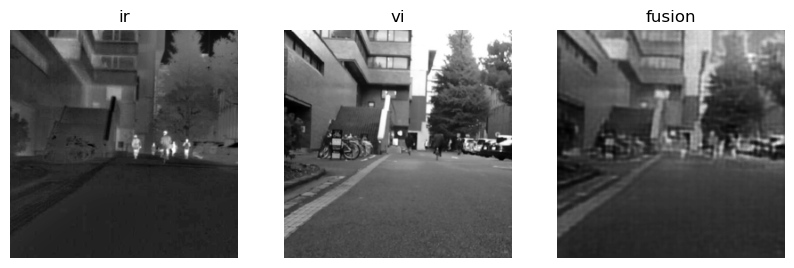

D_epoch_loss:0.0020142947049701914,G_epoch_loss1.6813520613838644
Epoch: 393 D_epoch_loss:0.0020425085128997177,G_epoch_loss1.6815194873248829
Epoch: 394 D_epoch_loss:0.0020820464432129964,G_epoch_loss1.6814918518066406
Epoch: 395 D_epoch_loss:0.0018341929980498902,G_epoch_loss1.6806909477009493
Epoch: 396 D_epoch_loss:0.0018667854943915324,G_epoch_loss1.6824296572629143
Epoch: 397 D_epoch_loss:0.0018043901209774263,G_epoch_loss1.681602856692146
Epoch: 398 D_epoch_loss:0.0018604633959886782,G_epoch_loss1.6822935272665585
Epoch: 399 D_epoch_loss:0.0018171812887029612,G_epoch_loss1.680084698340472
Epoch: 400 D_epoch_loss:0.0017642323064672597,G_epoch_loss1.6791394177605123
Epoch: 401 D_epoch_loss:0.0015074650017435059,G_epoch_loss1.6810677472282858
Epoch: 402 D_epoch_loss:0.0017814415452234885,G_epoch_loss1.6791412479737227
Epoch: 403 D_epoch_loss:0.0014446931685704518,G_epoch_loss1.6808367056005142
Epoch: 404 D_epoch_loss:0.0013871912823935203,G_epoch_loss1.679109860869015
Epoch: 405 D_

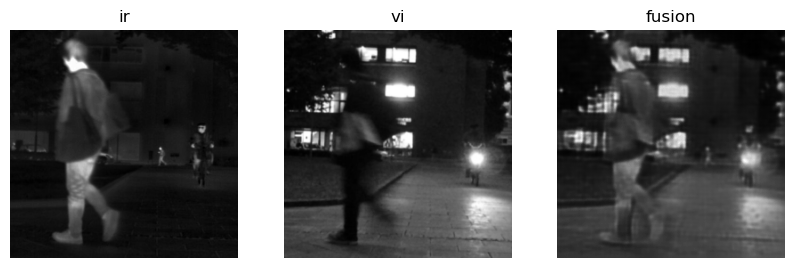

D_epoch_loss:0.00029940308527062265,G_epoch_loss1.6770105642430924
Epoch: 442 D_epoch_loss:0.00020780840328798685,G_epoch_loss1.674122270415811
Epoch: 443 D_epoch_loss:0.0003500632755115957,G_epoch_loss1.6750875290702372
Epoch: 444 D_epoch_loss:0.00033529771676780106,G_epoch_loss1.6747387086643892
Epoch: 445 D_epoch_loss:0.0002867318484384347,G_epoch_loss1.6723156045464909
Epoch: 446 D_epoch_loss:0.00028243212727829814,G_epoch_loss1.6750939944211174
Epoch: 447 D_epoch_loss:0.0003275959564181154,G_epoch_loss1.6739855233360739
Epoch: 448 D_epoch_loss:0.00023414027921663707,G_epoch_loss1.67383312477785
Epoch: 449 D_epoch_loss:0.0002112615727716783,G_epoch_loss1.6728536802179672
Epoch: 450 D_epoch_loss:0.00021632510384626905,G_epoch_loss1.672929188784431
Epoch: 451 D_epoch_loss:0.00020233738220721374,G_epoch_loss1.6738807664198034
Epoch: 452 D_epoch_loss:0.0002480966825661359,G_epoch_loss1.6737326243344475
Epoch: 453 D_epoch_loss:0.00020514306507881403,G_epoch_loss1.6720124412985409
Epoch:

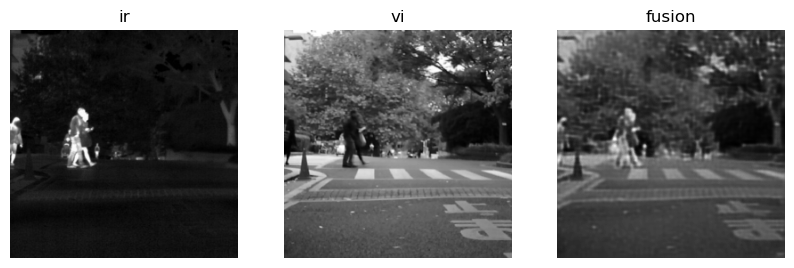

D_epoch_loss:0.00033770829844904845,G_epoch_loss1.664831785594716
Epoch: 491 D_epoch_loss:0.0003997926062712555,G_epoch_loss1.6632374244577743
Epoch: 492 D_epoch_loss:0.0007155358685207937,G_epoch_loss1.6626643573536593
Epoch: 493 D_epoch_loss:0.0003943886429838398,G_epoch_loss1.6607732983196484
Epoch: 494 D_epoch_loss:0.00031314361138570616,G_epoch_loss1.661337368628558
Epoch: 495 D_epoch_loss:0.0002813801641904694,G_epoch_loss1.663127716849832
Epoch: 496 D_epoch_loss:0.000239253141283852,G_epoch_loss1.6619113894069897
Epoch: 497 D_epoch_loss:0.0002812248032355188,G_epoch_loss1.663201745818643
Epoch: 498 D_epoch_loss:0.00035087176622576355,G_epoch_loss1.6607354248271269
Epoch: 499 D_epoch_loss:0.0003020490159328534,G_epoch_loss1.6615169749540442
Epoch: 500 D_epoch_loss:0.00026787627789684953,G_epoch_loss1.66240674607894
Epoch: 501 D_epoch_loss:0.0003020594680599649,G_epoch_loss1.6628125204759485
Epoch: 502 D_epoch_loss:0.0003654181087125942,G_epoch_loss1.6589210945017197
Epoch: 503 D_

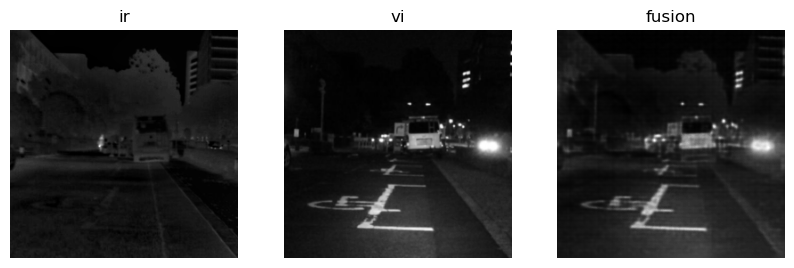

D_epoch_loss:0.00016692048388101873,G_epoch_loss1.6498175649081959
Epoch: 540 D_epoch_loss:0.00013081709916792426,G_epoch_loss1.6517149420345532
Epoch: 541 D_epoch_loss:8.454257284243153e-05,G_epoch_loss1.6485627679263843
Epoch: 542 D_epoch_loss:0.000308123251028626,G_epoch_loss1.6477371173746445
Epoch: 543 D_epoch_loss:9.349814846406363e-05,G_epoch_loss1.6482871420243208
Epoch: 544 D_epoch_loss:0.00015916339757763234,G_epoch_loss1.6505100516711964
Epoch: 545 D_epoch_loss:0.0001380000581668676,G_epoch_loss1.6470931277555578
Epoch: 546 D_epoch_loss:0.0001221555107536808,G_epoch_loss1.6476840411915499
Epoch: 547 D_epoch_loss:0.00012406810513793435,G_epoch_loss1.6485083173303043
Epoch: 548 D_epoch_loss:9.534982382319868e-05,G_epoch_loss1.6469392425873701
Epoch: 549 D_epoch_loss:9.881797739260091e-05,G_epoch_loss1.6477580841849833
Epoch: 550 D_epoch_loss:0.00010361066404798562,G_epoch_loss1.6455677467233993
Epoch: 551 D_epoch_loss:0.00010923120477373766,G_epoch_loss1.6486606177161722
Epoch

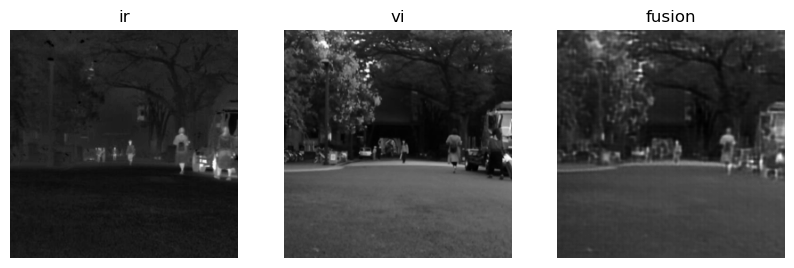

D_epoch_loss:7.015352377279401e-05,G_epoch_loss1.6371467604356653
Epoch: 589 D_epoch_loss:7.529444123707329e-05,G_epoch_loss1.6365943726371317
Epoch: 590 D_epoch_loss:0.00010660099788390867,G_epoch_loss1.6404945359510534
Epoch: 591 D_epoch_loss:0.00011147479124380933,G_epoch_loss1.6354460856493782
Epoch: 592 D_epoch_loss:7.059313900433207e-05,G_epoch_loss1.63684722255258
Epoch: 593 D_epoch_loss:7.548460320429192e-05,G_epoch_loss1.638270714703728
Epoch: 594 D_epoch_loss:5.5305631737128883e-05,G_epoch_loss1.6364637262680952
Epoch: 595 D_epoch_loss:0.00010916427441663793,G_epoch_loss1.6354255536023308
Epoch: 596 D_epoch_loss:8.316876215651385e-05,G_epoch_loss1.6355542435365564
Epoch: 597 D_epoch_loss:7.158475348071934e-05,G_epoch_loss1.6348051253487081
Epoch: 598 D_epoch_loss:0.03479172518221757,G_epoch_loss1.5858610167222864
Epoch: 599 D_epoch_loss:0.001956283633583499,G_epoch_loss1.6353154182434082
Epoch: 600 D_epoch_loss:0.0005946707019842614,G_epoch_loss1.6354171388289507
Epoch: 601 D

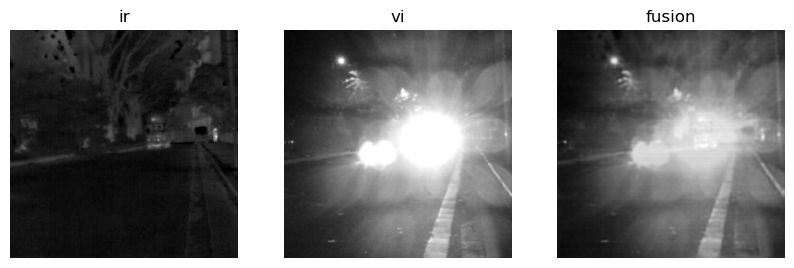

D_epoch_loss:0.00010313618430004949,G_epoch_loss1.6278225814594942
Epoch: 638 D_epoch_loss:8.456583300893031e-05,G_epoch_loss1.6276161320069258
Epoch: 639 D_epoch_loss:8.469773392254651e-05,G_epoch_loss1.6268415310803581
Epoch: 640 D_epoch_loss:0.00010682821673125385,G_epoch_loss1.6272076157962574
Epoch: 641 D_epoch_loss:5.088458762175458e-05,G_epoch_loss1.6271585085812736
Epoch: 642 D_epoch_loss:0.0001457121169925599,G_epoch_loss1.6273234241149004
Epoch: 643 D_epoch_loss:9.37426650446415e-05,G_epoch_loss1.6258494292988497
Epoch: 644 D_epoch_loss:0.00011302585891612312,G_epoch_loss1.6276230812072754
Epoch: 645 D_epoch_loss:9.111156503101537e-05,G_epoch_loss1.625409119269427
Epoch: 646 D_epoch_loss:0.00010590607245617052,G_epoch_loss1.6270939392202042
Epoch: 647 D_epoch_loss:9.53178663193659e-05,G_epoch_loss1.6264763018664192
Epoch: 648 D_epoch_loss:5.595053142529008e-05,G_epoch_loss1.625134306795457
Epoch: 649 D_epoch_loss:0.00011499546219377353,G_epoch_loss1.6252086092444027
Epoch: 65

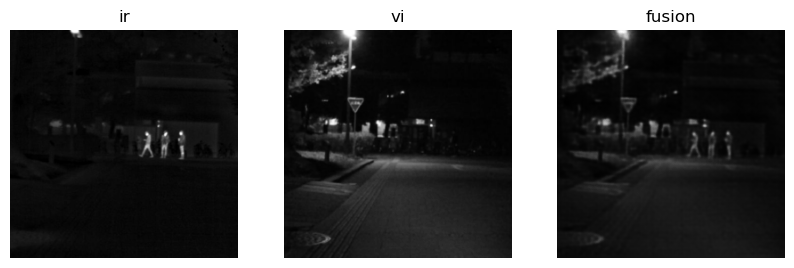

D_epoch_loss:2.6497558364473446e-05,G_epoch_loss1.6168089614194983
Epoch: 687 D_epoch_loss:5.229127124467221e-05,G_epoch_loss1.6174421029932358
Epoch: 688 D_epoch_loss:4.5626062595093734e-05,G_epoch_loss1.6158562057158525
Epoch: 689 D_epoch_loss:4.0190104969309794e-05,G_epoch_loss1.6154777162215288
Epoch: 690 D_epoch_loss:3.0426888449309283e-05,G_epoch_loss1.6175025982015274
Epoch: 691 D_epoch_loss:3.372460332684568e-05,G_epoch_loss1.6156881486668306
Epoch: 692 D_epoch_loss:0.00011888489579552483,G_epoch_loss1.615526655141045
Epoch: 693 D_epoch_loss:4.987611159509363e-05,G_epoch_loss1.6160861884846407
Epoch: 694 D_epoch_loss:3.168789274187635e-05,G_epoch_loss1.6149591908735388
Epoch: 695 D_epoch_loss:4.150308091886793e-05,G_epoch_loss1.614183601211099
Epoch: 696 D_epoch_loss:0.00044350756476941406,G_epoch_loss1.613695923019858
Epoch: 697 D_epoch_loss:0.00016413406464219887,G_epoch_loss1.613326304099139
Epoch: 698 D_epoch_loss:0.00010469512541449683,G_epoch_loss1.61335850463194
Epoch: 6

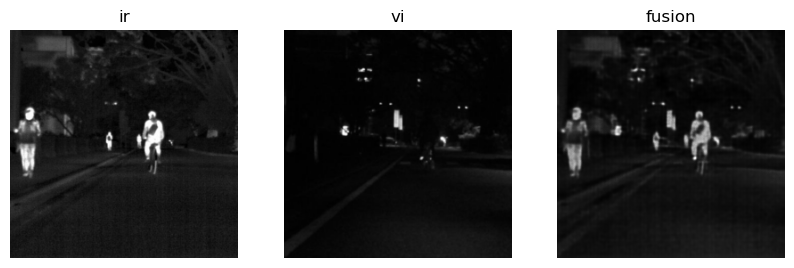

D_epoch_loss:3.957794444217785e-05,G_epoch_loss1.6072648342917948
Epoch: 736 D_epoch_loss:2.620688642577186e-05,G_epoch_loss1.6052018614376293
Epoch: 737 D_epoch_loss:3.4277571745299024e-05,G_epoch_loss1.6051332179237814
Epoch: 738 D_epoch_loss:2.4787975475834065e-05,G_epoch_loss1.6079669559703154
Epoch: 739 D_epoch_loss:2.5535642233829576e-05,G_epoch_loss1.6029728580923641
Epoch: 740 D_epoch_loss:5.405143132092609e-05,G_epoch_loss1.6069743703393375
Epoch: 741 D_epoch_loss:5.028025910124758e-05,G_epoch_loss1.6037533914341646
Epoch: 742 D_epoch_loss:2.2618655801873983e-05,G_epoch_loss1.6038144756765926
Epoch: 743 D_epoch_loss:2.6585129570080692e-05,G_epoch_loss1.6060463961432963
Epoch: 744 D_epoch_loss:3.636829928034465e-05,G_epoch_loss1.6043986502815695
Epoch: 745 D_epoch_loss:3.158445580244434e-05,G_epoch_loss1.6039597146651323
Epoch: 746 D_epoch_loss:9.937286682436345e-05,G_epoch_loss1.6030972985660328
Epoch: 747 D_epoch_loss:3.638624684754177e-05,G_epoch_loss1.60432048404918
Epoch: 

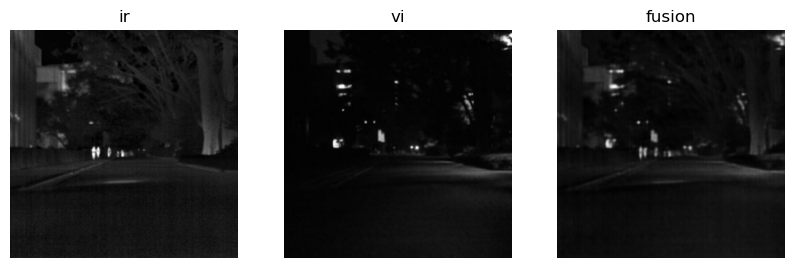

D_epoch_loss:1.6587791178073315e-05,G_epoch_loss1.5959283183602726
Epoch: 785 D_epoch_loss:1.5335954819473793e-05,G_epoch_loss1.5958139615900375
Epoch: 786 D_epoch_loss:1.1781330158555647e-05,G_epoch_loss1.5958835307289572
Epoch: 787 D_epoch_loss:2.066615573258947e-05,G_epoch_loss1.5954496720257927
Epoch: 788 D_epoch_loss:4.434758089059067e-05,G_epoch_loss1.594929204267614
Epoch: 789 D_epoch_loss:1.733939493800897e-05,G_epoch_loss1.593881319550907
Epoch: 790 D_epoch_loss:3.3020815943232534e-05,G_epoch_loss1.597900159218732
Epoch: 791 D_epoch_loss:2.0238006581006202e-05,G_epoch_loss1.5929220704471363
Epoch: 792 D_epoch_loss:1.6186631214890548e-05,G_epoch_loss1.5952536218306597
Epoch: 793 D_epoch_loss:2.2823899571984145e-05,G_epoch_loss1.5946879106409408
Epoch: 794 D_epoch_loss:0.00010660015844704878,G_epoch_loss1.594433679300196
Epoch: 795 D_epoch_loss:2.5965470553380918e-05,G_epoch_loss1.5925384900149178
Epoch: 796 D_epoch_loss:2.0680426453455928e-05,G_epoch_loss1.5917668833452112
Epoc

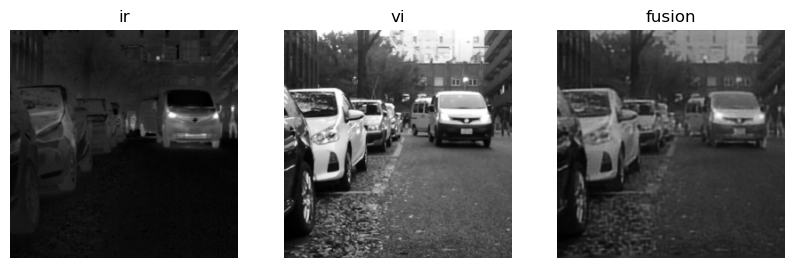

D_epoch_loss:1.0383430649466498e-05,G_epoch_loss1.586253986639135
Epoch: 834 D_epoch_loss:1.589285812662959e-05,G_epoch_loss1.5847691507900463
Epoch: 835 D_epoch_loss:9.845859173818848e-06,G_epoch_loss1.5857199640835034
Epoch: 836 D_epoch_loss:1.172648558167566e-05,G_epoch_loss1.5848303752786972
Epoch: 837 D_epoch_loss:1.4265591971707181e-05,G_epoch_loss1.5837513068143059
Epoch: 838 D_epoch_loss:6.178950113334234e-05,G_epoch_loss1.586328106767991
Epoch: 839 D_epoch_loss:1.36315221853318e-05,G_epoch_loss1.5829080062754013
Epoch: 840 D_epoch_loss:1.0700930127260268e-05,G_epoch_loss1.5855702021542717
Epoch: 841 D_epoch_loss:1.887972471462597e-05,G_epoch_loss1.5835834531223072
Epoch: 842 D_epoch_loss:2.0663004761445336e-05,G_epoch_loss1.584454760831945
Epoch: 843 D_epoch_loss:8.93644492220226e-06,G_epoch_loss1.5825953062842875
Epoch: 844 D_epoch_loss:1.4220149002058487e-05,G_epoch_loss1.5818700930651497
Epoch: 845 D_epoch_loss:1.5702571451637434e-05,G_epoch_loss1.5860258060343124
Epoch: 84

In [ ]:
D_loss = []
G_loss = []
res = []
for epoch in range(5000):
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(train_dl)
    for step,(vi,ir) in enumerate(train_dl):
        ir = ir.to(device)
        vi = vi.to(device)
        d_optimizer.zero_grad()
        #输入真实图片，判别器判定为真
        disc_real_output = dis(vi) #输入真实的图片
        d_real_loss = loss_fn(disc_real_output,torch.ones_like(disc_real_output,device = device))
        d_real_loss.backward() # 反向传播
        #生成图片
        gen_output = gen(vi,ir) #生成图片
        vi_disc_gen_output = dis(gen_output.detach()) #输入生成图像，判断可见光
        vi_d_fake_loss = loss_fn(vi_disc_gen_output,torch.zeros_like(vi_disc_gen_output,device = device))
        vi_d_fake_loss.backward() #生成图片进入判别器进行反向传播
        # 判定器的loss由两部分组成
        disc_loss = d_real_loss + vi_d_fake_loss
        #更新判别器参数
        d_optimizer.step()
        g_optimizer.zero_grad()
        # 将生成的图片放入判别器，要求骗过判别器
        vi_disc_gen_out = dis(gen_output.detach())
        # 得到生成器的损失
        vi_gen_loss_crossentropyloss = loss_fn(vi_disc_gen_out,torch.ones_like(vi_disc_gen_out,device = device))
        
        # vi_gen_l1_loss = torch.mean(torch.abs(gen_output - vi*0.5 - ir*0.5))
        epsilon = 5.0
        vi_gen_l1_loss = torch.mean(torch.square(gen_output - 0.5*ir - 0.5*vi)) + epsilon * torch.mean(
            torch.square(
                gradient(gen_output)-
                0.5 * gradient(vi)-
                0.5*gradient(vi)
            )
        )
        gen_loss = vi_gen_loss_crossentropyloss+ LAMDA*(vi_gen_l1_loss)
        
        gen_loss.backward()
        #更新生成器梯度
        g_optimizer.step()
        with torch.no_grad():
            D_epoch_loss += disc_loss.item()
            G_epoch_loss += gen_loss.item()
    with torch.no_grad():
        D_epoch_loss /=count
        G_epoch_loss /=count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        # 训练完一个epoch就打印输出
        print("Epoch:",epoch,end=' ')
        if epoch%49==0:
            ress = genarate_images(gen,ir,vi)
            res.append(ress)
        print(f'D_epoch_loss:{D_epoch_loss},G_epoch_loss{G_epoch_loss}')